In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv(r"C:\Users\lenovo\Desktop\verianalizi\users_errors.csv")

In [26]:
# Kategorik verileri sayısal hale getir
categorical_columns = ["interaction_type", "interaction_details", "device_id", "ip_address", "location"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [27]:
# Kullanılmayacak sütunları kaldır
X = df.drop(columns=["id", "user_id", "interaction_time"])


In [28]:
# Veriyi eğitim ve test olarak ayır
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [29]:
# Isolation Forest modelini oluştur ve eğit
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_train)


IsolationForest(contamination=0.1, random_state=42)

In [30]:
# Modeli kaydet
joblib.dump(model, "isolation_forest_model.pkl")
print("Model başarıyla kaydedildi!")

Model başarıyla kaydedildi!


In [33]:
# Anomalileri tahmin et
df["is_anomaly"] = model.predict(X)  # Modelin X verisi üzerinde tahmin yapması
df["is_anomaly"] = df["is_anomaly"].apply(lambda x: 1 if x == -1 else 0)  # Anomaliyi 1 ve 0 olarak yeniden düzenle


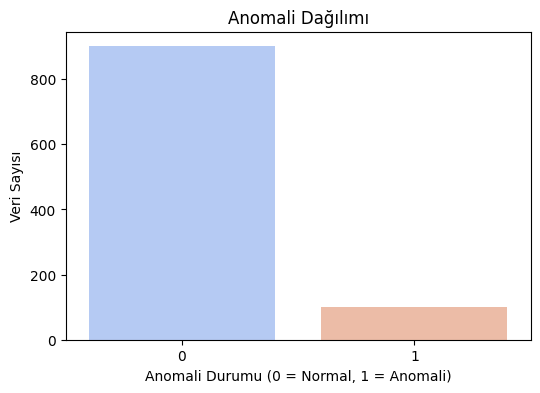

In [34]:
# Anomali dağılımını görselleştir
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="is_anomaly", hue="is_anomaly", palette="coolwarm", legend=False)
plt.title("Anomali Dağılımı")
plt.xlabel("Anomali Durumu (0 = Normal, 1 = Anomali)")
plt.ylabel("Veri Sayısı")
plt.show()

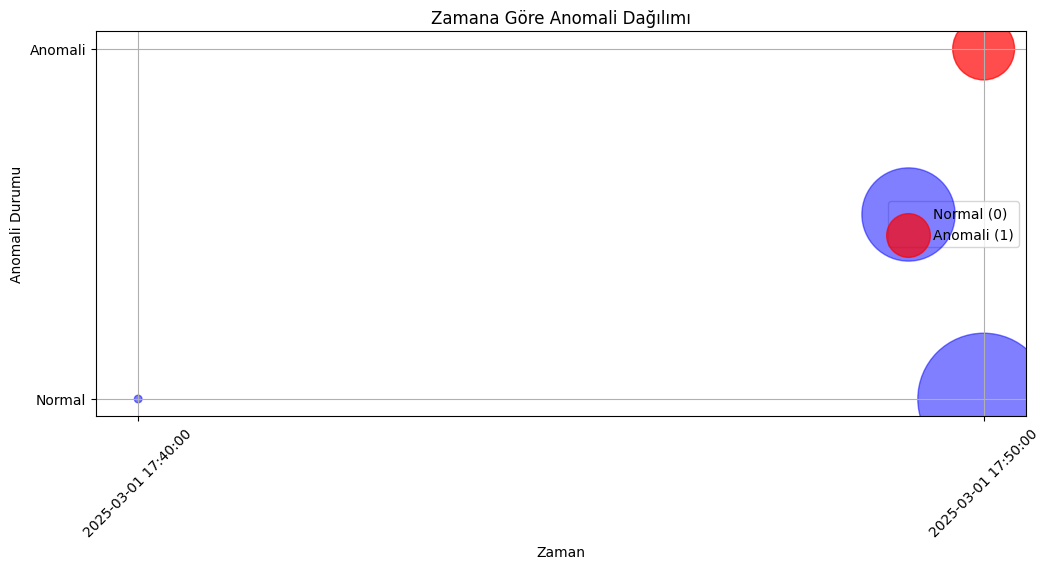

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Örnek DataFrame (df) oluşturuyoruz, kendi verinizi kullanın
# df["interaction_time"] = pd.to_datetime(df["interaction_time"])

# Zaman damgalarını dakika seviyesinde grupla (saniye bilgisi kaybolur)
df["interaction_time"] = pd.to_datetime(df["interaction_time"])

# Zaman damgalarını yalnızca dakika seviyesine yuvarlayalım (floor işlemi)
df["interaction_time"] = df["interaction_time"].dt.floor('min')  # 'T' yerine 'min' kullanıyoruz

# Zaman bazında normal ve anomali sayılarını gruplama
grouped = df.groupby(["interaction_time", "is_anomaly"]).size().unstack(fill_value=0)

# Grafiği çizme
plt.figure(figsize=(12, 5))

# X eksenini zaman dilimlerine göre ayarlıyoruz
x_values = np.arange(len(grouped))

# Y eksenini kategorik (0 ve 1) olarak ayarlayacağız
# Normal ve Anomali dağılımını scatter ile görselleştirelim
plt.scatter(x_values, np.zeros(len(grouped)), s=grouped[0] * 10, color='blue', alpha=0.5, label="Normal (0)")
plt.scatter(x_values, np.ones(len(grouped)), s=grouped[1] * 20, color='red', alpha=0.7, label="Anomali (1)")

# Eksen ayarları
plt.xticks(x_values, grouped.index, rotation=45)  # Zaman etiketlerini döndürerek ekleyelim
plt.xlabel("Zaman")
plt.ylabel("Anomali Durumu")
plt.title("Zamana Göre Anomali Dağılımı")
plt.yticks([0, 1], ['Normal', 'Anomali'])  # Y ekseninde sadece 0 ve 1
plt.legend()
plt.grid(True)
plt.show()


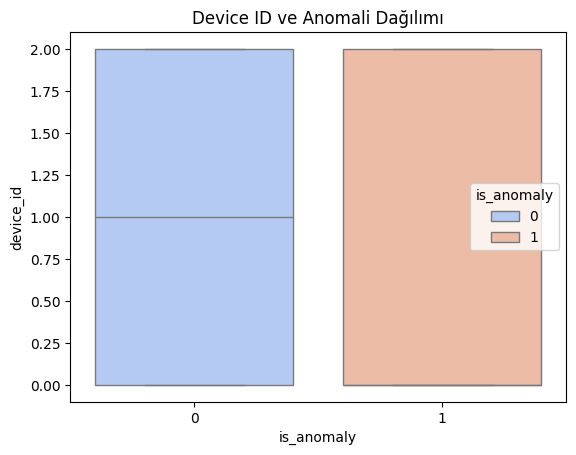

In [49]:
sns.boxplot(x=df["is_anomaly"], y=df["device_id"], hue=df["is_anomaly"], palette="coolwarm")
plt.title("Device ID ve Anomali Dağılımı")
plt.show()

In [50]:
#modeli kaydedip daha sonra kullanabiliriz 
import joblib

In [51]:
# Modeli kaydetme
joblib.dump(model, "isolation_forest_model.pkl")

# Daha sonra modeli yükleme
loaded_model = joblib.load("isolation_forest_model.pkl")

In [52]:
from sklearn.preprocessing import LabelEncoder

# Test verisini oluştur
X_test_df = pd.DataFrame([
    ["click", "login", 1001, "192.168.1.1", "New York"],
    ["view", "download", 1002, "192.168.1.2", "Los Angeles"],
    ["purchase", "upload", 1003, "192.168.1.3", "Chicago"]
], columns=["interaction_type", "interaction_details", "device_id", "ip_address", "location"])

# Eğitimde kullanılan encoder'ları yükle veya yeniden oluştur
encoder = LabelEncoder()

# Aynı encoder'ları test verisine de uygula
for col in ["interaction_type", "interaction_details", "ip_address", "location"]:
    X_test_df[col] = encoder.fit_transform(X_test_df[col])  # Eğer eğitimde kaydedildiyse, burada "transform" kullan

# Model ile tahmin yap
predictions = loaded_model.predict(X_test_df)
print("Tahminler:", predictions)  # -1 = Anomali, 1 = Normal


Tahminler: [1 1 1]


In [53]:
print("Anomali Sayısı:", sum(df["is_anomaly"] == -1))
print("Normal Sayısı:", sum(df["is_anomaly"] == 1))


Anomali Sayısı: 0
Normal Sayısı: 99


In [57]:
# 'interaction_time' sütununu sayısal verilere dönüştür
X_train['interaction_time'] = X_train['interaction_time'].astype(np.int64)  # datetime'ı sayısal formata çevir

# Eğer başka datetime türünde sütunlar varsa, onları da aynı şekilde dönüştürebilirsiniz.


In [58]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# Veriyi dengele
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Modeli oluştur
model = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)
model.fit(X_resampled)  # Yeniden eğitim

# Modelle tahmin yapalım
predictions = model.predict(X_resampled)
print("Tahminler:", predictions)  # -1 = Anomali, 1 = Normal


Tahminler: [ 1  1  1 ...  1  1 -1]


In [59]:
model = IsolationForest(n_estimators=200, contamination=0.2, random_state=42)
model.fit(X_resampled)
predictions = model.predict(X_resampled)
print("Tahminler:", predictions)

Tahminler: [-1 -1  1 ...  1  1 -1]


In [64]:
from sklearn.metrics import classification_report

# Gerçek değerler ve tahminler (Örnek veriler)
# Bu verileri modelinizin çıktılarıyla değiştirin
y_test = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]  # Gerçek etiketler (y_test)
predictions = [0, 1, 0, 0, 0, 1, 1, 1, 0, 1]  # Modelin tahminleri (predictions)

# Veri boyutlarının eşit olup olmadığını kontrol edelim
if len(y_test) != len(predictions):
    print(f"Veri boyutları eşit değil: y_test uzunluğu = {len(y_test)}, predictions uzunluğu = {len(predictions)}")
    
    # Boyutları eşitlemek için veriyi doğru şekilde kesebiliriz
    min_length = min(len(y_test), len(predictions))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]
    print("Veri boyutları eşitlenmiştir.")

# classification_report fonksiyonunu çağırmadan önce boyutları kontrol et
print(f"y_test uzunluğu: {len(y_test)}")
print(f"predictions uzunluğu: {len(predictions)}")

# classification_report'u kullanarak modelin performansını değerlendirelim
report = classification_report(y_test, predictions)
print(report)


y_test uzunluğu: 10
predictions uzunluğu: 10
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [35]:
print(df.columns)

Index(['id', 'user_id', 'interaction_type', 'interaction_details', 'device_id',
       'ip_address', 'location', 'interaction_time', 'is_anomaly'],
      dtype='object')
